Reinforcement Learning Pong Agent


In [1]:
%pip install gymnasium
%pip install gymnasium[atari]
%pip install gymnasium[accept-rom-license]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Imports

In [2]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import random
import cv2
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


Num GPUs Available:  0


Environment

In [3]:
env = gym.make("ALE/Pong-v5", render_mode='rgb_array') # create environment
env = gym.wrappers.RecordVideo(env, './videos', episode_trigger=lambda episode_id: True, video_length=0)
action_space_n = env.action_space.n

c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\.venv\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Model

In [4]:
# hyperparameter
learning_rate = 0.001
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
batch_size = 64
num_episodes = 1000
frame_skip = 10 # number of frames to skip 


# model architecture
def create_model(action_space_n):
    input_layer = layers.Input(shape=(84, 84, 4)) # input shape is 84x84x4
    conv1 = layers.Conv2D(32, (8, 8), strides=(4, 4), activation='relu')(input_layer) # 32 filters of 8x8 with stride 4
    conv2 = layers.Conv2D(64, (4, 4), strides=(2, 2), activation='relu')(conv1) # 64 filters of 4x4 with stride 2
    conv3 = layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu')(conv2) # 64 filters of 3x3 with stride 1
    flatten = layers.Flatten()(conv3) # flatten the output
    dense1 = layers.Dense(512, activation='relu')(flatten) # dense layer with 512 units
    output_layer = layers.Dense(action_space_n, activation='linear')(dense1) # output layer with action_space_n units
    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

# agent initialization
model = create_model(action_space_n)
target_model = create_model(action_space_n)
target_model.set_weights(model.get_weights())

optimizer = tf.keras.optimizers.Adam(learning_rate)
huber_loss = tf.keras.losses.Huber()

# Experience Replay Buffer
class ExperienceReplayBuffer:
    def __init__(self, capacity=10000): # capacity of the buffer
        self.capacity = capacity
        self.buffer = []
        self.position = 0
 
    def add(self, state, action, reward, next_state, done): # add experience to the buffer
        if len(self.buffer) < self.capacity: 
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done) # add experience to the buffer
        self.position = (self.position + 1) % self.capacity # update position

    def sample(self, batch_size): # sample experience from the buffer
        return zip(*random.sample(self.buffer, batch_size)) # return a batch of experiences

# Preprocessing function for the state
def preprocess_state(state): 
    gray_state = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY) # convert to grayscale
    resized_state = cv2.resize(gray_state, (84, 84)) # resize to 84x84
    return resized_state.astype(np.float32) / 255.0 # normalize

# plots
def plot_results(episode_rewards, episode_lengths, episode_losses, epsilon_values, save_path):
    plt.figure(figsize=(12, 10))

    plt.subplot(4, 1, 1) 
    plt.plot(episode_rewards, label="Total Reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(episode_lengths, label="Episode Length")
    plt.xlabel("Episode")
    plt.ylabel("Length")
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(episode_losses, label="Loss")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(epsilon_values, label="Epsilon")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.legend()

    plt.tight_layout()
    
    # Save plot before showing
    plt.savefig(save_path)
    plt.show()


In [5]:
# class PrioritizedExperienceReplayBuffer:
#     def __init__(self, capacity=10000, alpha=0.6, beta=0.4, beta_increment_per_sampling=0.001, epsilon=0.01):
#         self.capacity = capacity
#         self.alpha = alpha
#         self.beta = beta
#         self.beta_increment_per_sampling = beta_increment_per_sampling
#         self.epsilon = epsilon
#         self.buffer = []
#         self.priorities = np.zeros((capacity,), dtype=np.float32)
#         self.position = 0
#         self.priorities_sum = 1.0

#     def add(self, state, action, reward, next_state, done):
#         priority = np.max(self.priorities) if self.buffer else 1.0
#         experience = (state, action, reward, next_state, done)
#         if len(self.buffer) < self.capacity:
#             self.buffer.append(experience)
#         else:
#             self.buffer[self.position] = experience
#         self.priorities[self.position] = priority
#         self.position = (self.position + 1) % self.capacity

#     def sample(self, batch_size):
#         if len(self.buffer) == self.capacity:
#             priorities = self.priorities
#         else:
#             priorities = self.priorities[:self.position]
#         probabilities = priorities ** self.alpha
#         probabilities /= np.sum(probabilities)  # Normalizing probabilities to sum up to 1
#         indices = np.random.choice(len(self.buffer), size=batch_size, p=probabilities)
#         samples = [self.buffer[idx] for idx in indices]
#         weights = (len(self.buffer) * probabilities[indices]) ** (-self.beta)
#         weights /= weights.max()
#         self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])
#         return samples, indices, weights

#     def update_priorities(self, indices, priorities):
#         self.priorities[indices] = priorities
#         self.priorities_sum = np.sum(self.priorities)

In [6]:
# # Training metrics
# episode_rewards = []
# episode_lengths = []
# episode_losses = []

# buffer = PrioritizedExperienceReplayBuffer(capacity=10000, alpha=alpha, beta=beta)

# record_env = None
# videos_dir = "videos"
# os.makedirs(videos_dir, exist_ok=True)

# best_reward = -float('inf')

# for episode in range(num_episodes):
#     if (episode + 1) % 25 == 0:
#         if record_env is not None:
#             record_env.close()
#         video_path = os.path.join(videos_dir, f"episode_{episode + 1}")
#         record_env = gym.wrappers.RecordVideo(env, video_path, episode_trigger=lambda episode_id: True, video_length=0)
#     else:
#         env.reset()

#     state, info = env.reset()
#     state = preprocess_state(state)
#     state = np.stack([state] * 4, axis=2)
#     done = False
#     total_reward = 0
#     step = 0
#     losses = []

#     while not done:
#         if np.random.rand() <= epsilon:
#             action = env.action_space.sample()
#         else:
#             action = np.argmax(model.predict(np.expand_dims(state, axis=0), verbose=0))

#         for _ in range(frame_skip):
#             next_state, reward, done, truncated, info = env.step(action)
#             done = done or truncated
#             total_reward += reward
#             if done:
#                 break

#         next_state, reward, done, truncated, info = env.step(action)
#         done = done or truncated

#         next_state = preprocess_state(next_state)
#         next_state = np.append(state[:, :, 1:], np.expand_dims(next_state, axis=2), axis=2)

#         total_reward += reward

#         buffer.add(state, action, reward, next_state, done)

#         state = next_state
#         step += 1

#         if len(buffer.buffer) > batch_size:
#             samples, indices, weights = buffer.sample(batch_size)
#             states, actions, rewards, next_states, dones = zip(*samples)

#             future_rewards = target_model.predict(np.array(next_states), verbose=0)
#             dones = np.array(dones, dtype=int)
#             updated_q_values = rewards + discount_factor * np.max(future_rewards, axis=1) * (1 - dones)

#             masks = tf.one_hot(actions, action_space_n)

#             with tf.GradientTape() as tape:
#                 q_values = model(np.array(states))
#                 q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
#                 loss = huber_loss(updated_q_values, q_action)
#                 weighted_loss = tf.reduce_mean(loss * weights)  # Weighted loss
#                 losses.append(weighted_loss.numpy())

#             grads = tape.gradient(weighted_loss, model.trainable_variables)
#             optimizer.apply_gradients(zip(grads, model.trainable_variables))

#             buffer.update_priorities(indices, loss.numpy())

#     episode_rewards.append(total_reward)
#     episode_lengths.append(step)
#     episode_losses.append(np.mean(losses))

#     print(f"Episode {episode + 1} abgeschlossen mit {step} Schritten, Gesamtbelohnung: {total_reward}, Epsilon: {epsilon}")

#     if episode % 10 == 0:
#         target_model.set_weights(model.get_weights())

#     epsilon = max(epsilon_min, epsilon * epsilon_decay)

#     if total_reward > best_reward:
#         best_reward = total_reward
#         model.save("best_pong_v5_rl_model.keras")

#     if (episode + 1) % 100 == 0:
#         model.save(f"pong_v5_rl_model_episode_{episode + 1}.keras")

#     if (episode + 1) % 5 == 0:
#         plot_results(episode_rewards, episode_lengths, episode_losses)

# if record_env is not None:
#     record_env.close()

# model.save("pong_rl_model.keras")

Training

Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-0.mp4
Episode 1 abgeschlossen mit 1001 Schritten, Gesamtbelohnung: -21.0, Epsilon: 1.0
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-1.mp4
Episode 2 abgeschlossen mit 1112 Schritten, Gesamtbelohnung: -20.0, Epsilon: 0.995
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-2.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-2.mp4
Episode 3 abgeschlossen mit 1023 Schritten, Gesamtbelohnung: -20.0, Epsilon: 0.990025
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-3.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-3.mp4
Episode 4 abgeschlossen mit 914 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.985074875
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-4.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-4.mp4
Episode 5 abgeschlossen mit 1114 Schritten, Gesamtbelohnung: -19.0, Epsilon: 0.9801495006250001
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-5.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-5.mp4
Episode 6 abgeschlossen mit 976 Schritten, Gesamtbelohnung: -19.0, Epsilon: 0.9752487531218751
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-6.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-6.mp4
Episode 7 abgeschlossen mit 971 Schritten, Gesamtbelohnung: -19.0, Epsilon: 0.9703725093562657
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-7.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-7.mp4
Episode 8 abgeschlossen mit 870 Schritten, Gesamtbelohnung: -20.0, Epsilon: 0.9655206468094844
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-8.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-8.mp4
Episode 9 abgeschlossen mit 880 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.960693043575437
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-9.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-9.mp4
Episode 10 abgeschlossen mit 960 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.9558895783575597


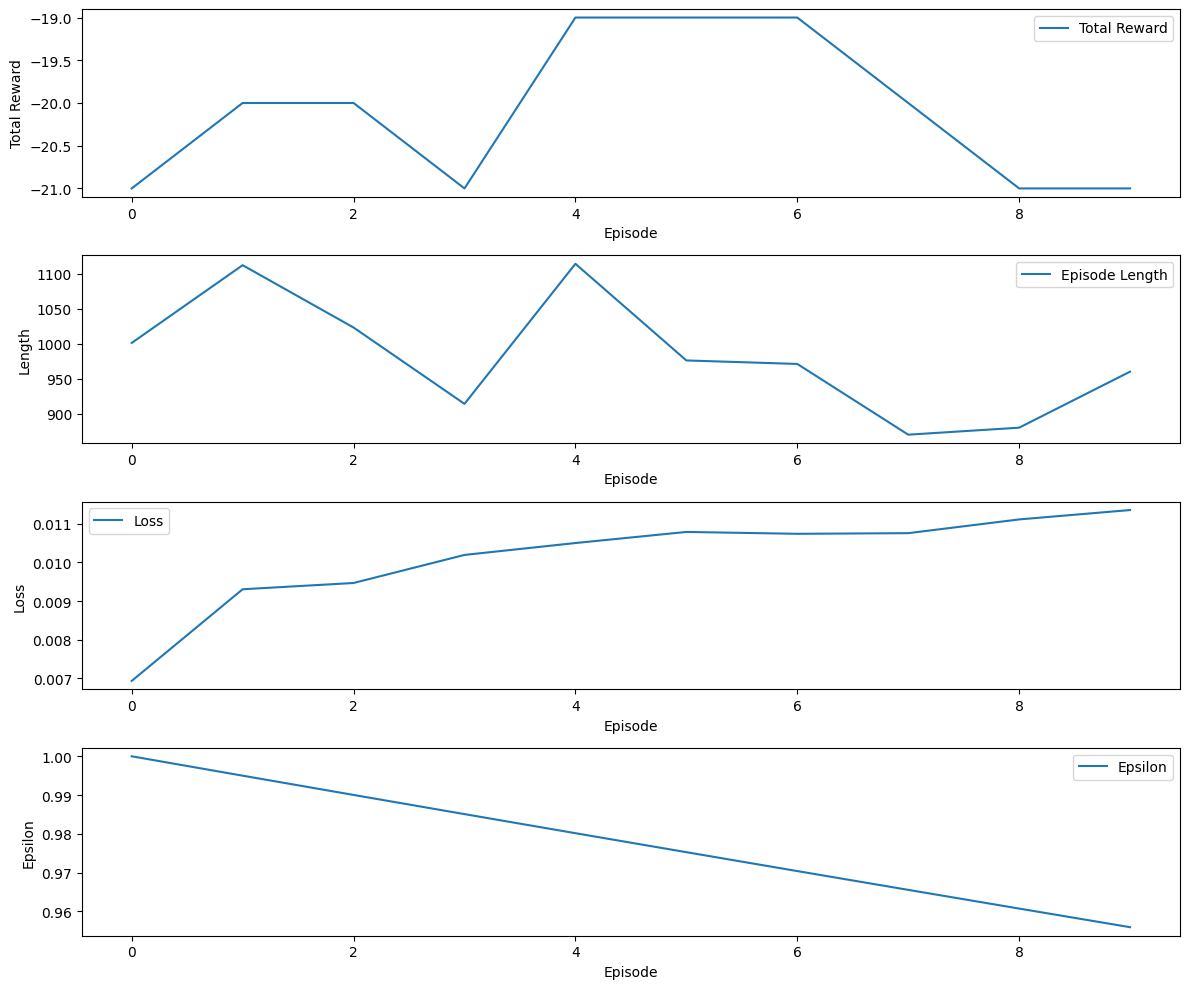

Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-10.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-10.mp4
Episode 11 abgeschlossen mit 881 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.9511101304657719
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-11.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-11.mp4
Episode 12 abgeschlossen mit 843 Schritten, Gesamtbelohnung: -20.0, Epsilon: 0.946354579813443
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-12.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-12.mp4
Episode 13 abgeschlossen mit 1079 Schritten, Gesamtbelohnung: -19.0, Epsilon: 0.9416228069143757
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-13.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-13.mp4
Episode 14 abgeschlossen mit 1029 Schritten, Gesamtbelohnung: -18.0, Epsilon: 0.9369146928798039
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-14.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-14.mp4
Episode 15 abgeschlossen mit 886 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.9322301194154049
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-15.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-15.mp4
Episode 16 abgeschlossen mit 967 Schritten, Gesamtbelohnung: -19.0, Epsilon: 0.9275689688183278
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-16.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-16.mp4
Episode 17 abgeschlossen mit 960 Schritten, Gesamtbelohnung: -20.0, Epsilon: 0.9229311239742362
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-17.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-17.mp4
Episode 18 abgeschlossen mit 1009 Schritten, Gesamtbelohnung: -19.0, Epsilon: 0.918316468354365
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-18.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-18.mp4
Episode 19 abgeschlossen mit 852 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.9137248860125932
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-19.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-19.mp4
Episode 20 abgeschlossen mit 968 Schritten, Gesamtbelohnung: -19.0, Epsilon: 0.9091562615825302


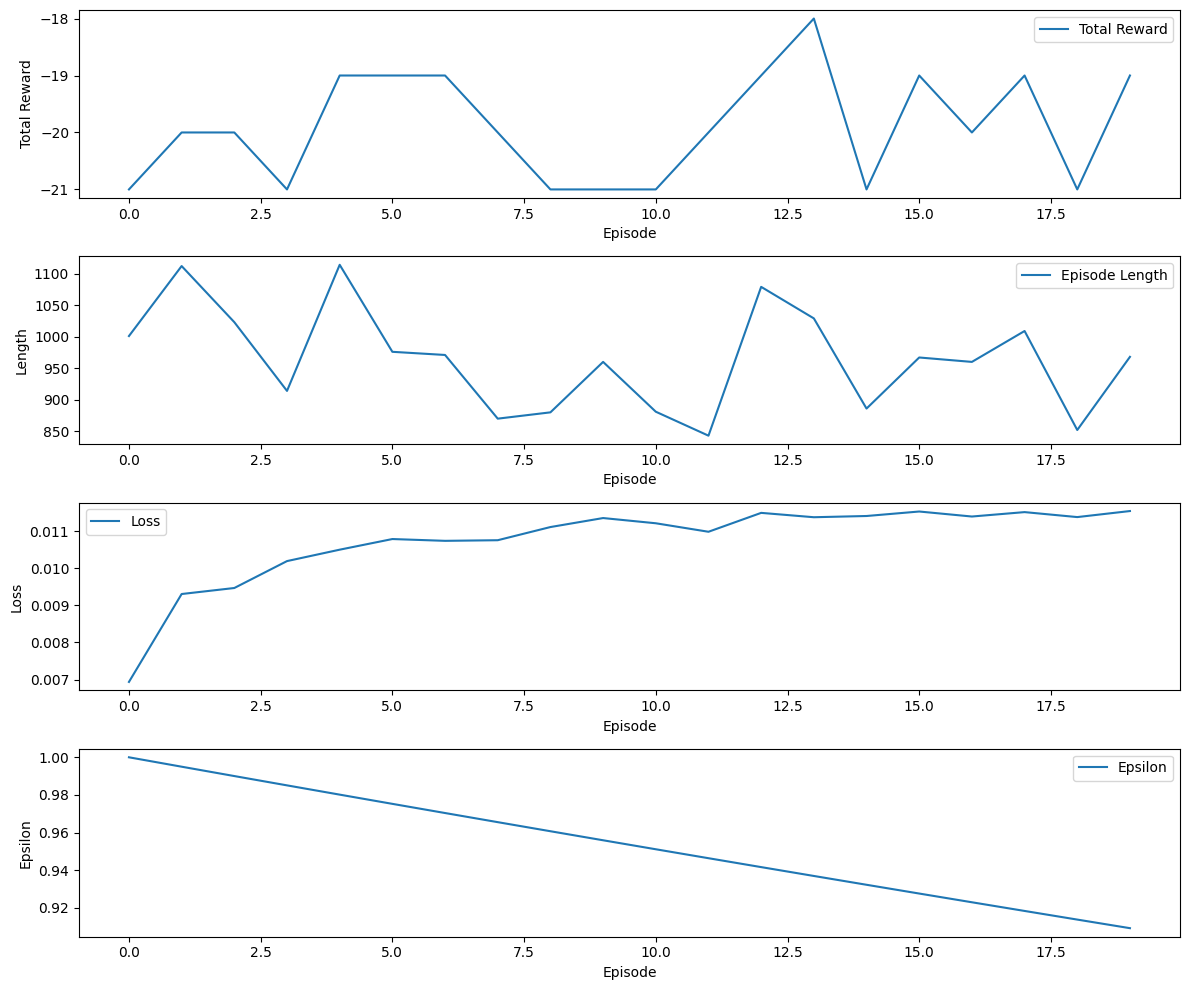

Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-20.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-20.mp4
Episode 21 abgeschlossen mit 842 Schritten, Gesamtbelohnung: -20.0, Epsilon: 0.9046104802746175
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-21.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-21.mp4
Episode 22 abgeschlossen mit 764 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.9000874278732445
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-22.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-22.mp4
Episode 23 abgeschlossen mit 978 Schritten, Gesamtbelohnung: -20.0, Epsilon: 0.8955869907338783
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-23.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-23.mp4
Episode 24 abgeschlossen mit 793 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.8911090557802088
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-24.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-24.mp4
Episode 25 abgeschlossen mit 924 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.8866535105013078
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-25.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-25.mp4
Episode 26 abgeschlossen mit 793 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.8822202429488013
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-26.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-26.mp4
Episode 27 abgeschlossen mit 873 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.8778091417340573
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-27.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-27.mp4
Episode 28 abgeschlossen mit 1105 Schritten, Gesamtbelohnung: -19.0, Epsilon: 0.8734200960253871
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-28.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-28.mp4
Episode 29 abgeschlossen mit 792 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.8690529955452602
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-29.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-29.mp4
Episode 30 abgeschlossen mit 1052 Schritten, Gesamtbelohnung: -19.0, Epsilon: 0.8647077305675338


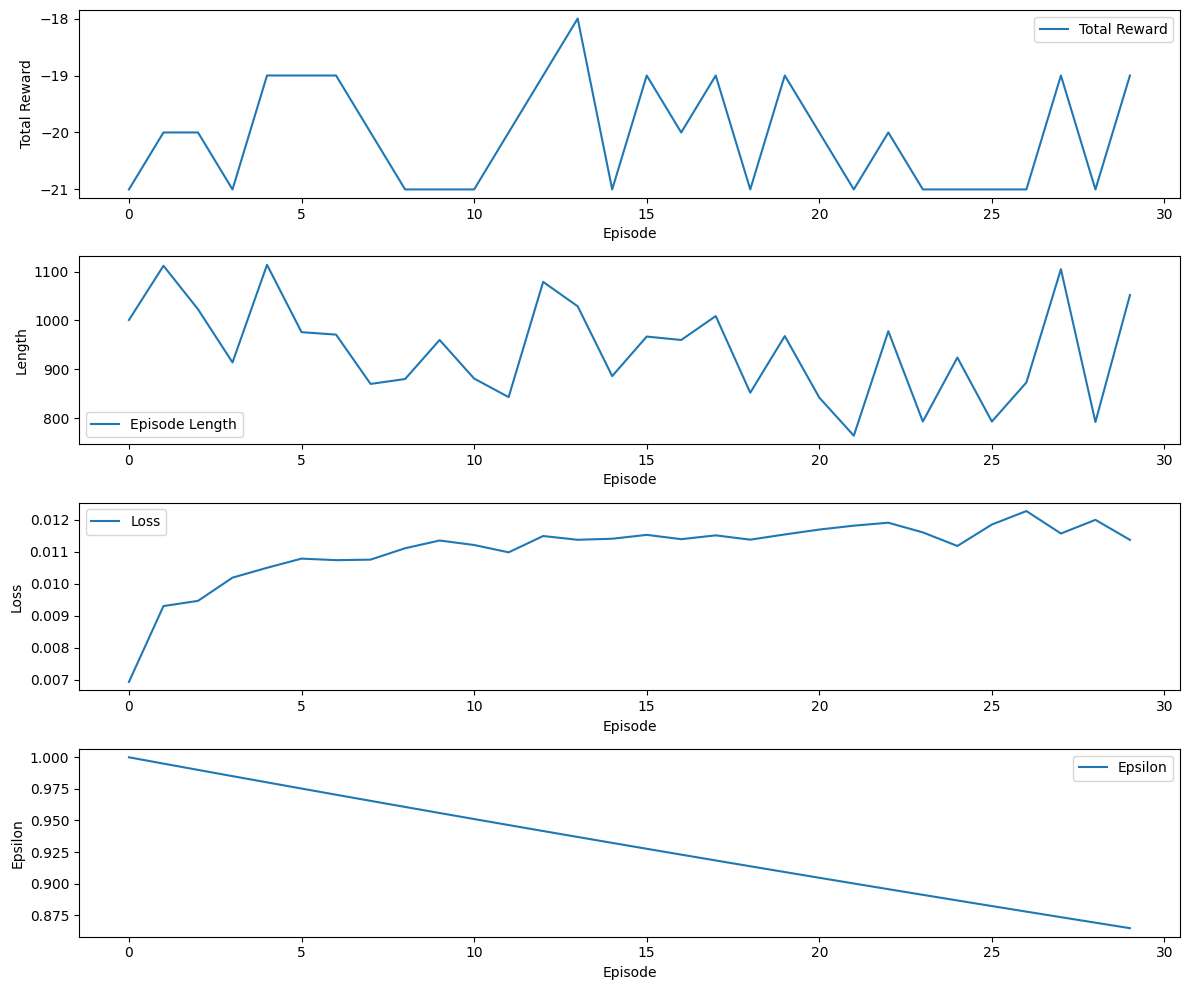

Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-30.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-30.mp4
Episode 31 abgeschlossen mit 1228 Schritten, Gesamtbelohnung: -18.0, Epsilon: 0.8603841919146962
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-31.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-31.mp4
Episode 32 abgeschlossen mit 975 Schritten, Gesamtbelohnung: -19.0, Epsilon: 0.8560822709551227
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-32.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-32.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-32.mp4
Episode 33 abgeschlossen mit 930 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.851801859600347
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-33.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-33.mp4
Episode 34 abgeschlossen mit 931 Schritten, Gesamtbelohnung: -20.0, Epsilon: 0.8475428503023453
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-34.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-34.mp4
Episode 35 abgeschlossen mit 860 Schritten, Gesamtbelohnung: -20.0, Epsilon: 0.8433051360508336
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-35.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-35.mp4
Episode 36 abgeschlossen mit 824 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.8390886103705794
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-36.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-36.mp4
Episode 37 abgeschlossen mit 984 Schritten, Gesamtbelohnung: -20.0, Epsilon: 0.8348931673187264
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-37.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-37.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-37.mp4
Episode 38 abgeschlossen mit 824 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.8307187014821328
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-38.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-38.mp4
Episode 39 abgeschlossen mit 820 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.8265651079747222
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-39.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-39.mp4
Episode 40 abgeschlossen mit 898 Schritten, Gesamtbelohnung: -20.0, Epsilon: 0.8224322824348486


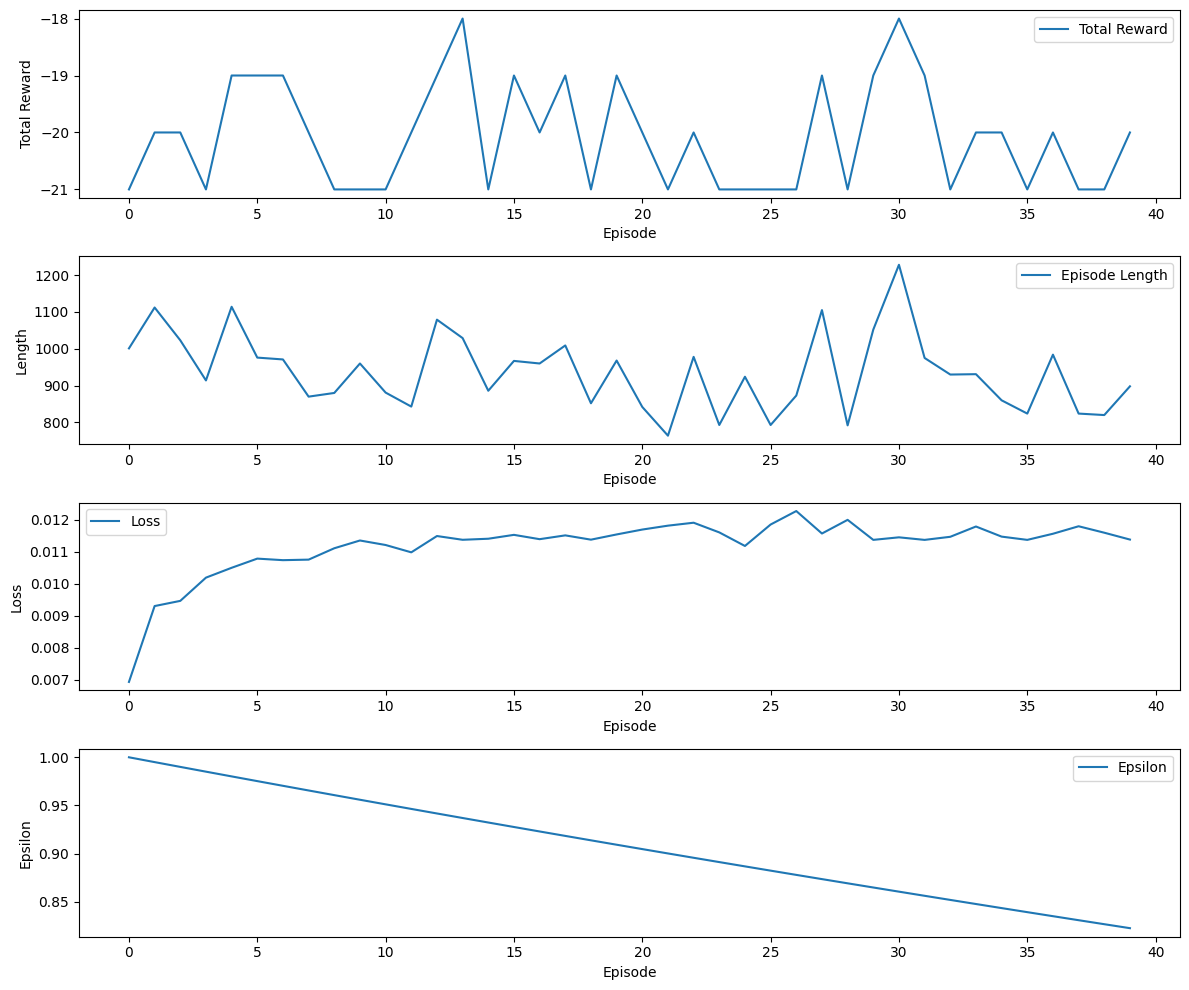

Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-40.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-40.mp4
Episode 41 abgeschlossen mit 764 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.8183201210226743
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-41.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-41.mp4
Episode 42 abgeschlossen mit 965 Schritten, Gesamtbelohnung: -20.0, Epsilon: 0.8142285204175609
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-42.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-42.mp4
Episode 43 abgeschlossen mit 824 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.810157377815473
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-43.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-43.mp4
Episode 44 abgeschlossen mit 852 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.8061065909263957
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-44.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-44.mp4
Episode 45 abgeschlossen mit 824 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.8020760579717637
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-45.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-45.mp4
Episode 46 abgeschlossen mit 981 Schritten, Gesamtbelohnung: -20.0, Epsilon: 0.798065677681905
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-46.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-46.mp4
Episode 47 abgeschlossen mit 852 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.7940753492934954
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-47.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-47.mp4
Episode 48 abgeschlossen mit 1118 Schritten, Gesamtbelohnung: -19.0, Epsilon: 0.7901049725470279
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-48.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-48.mp4
Episode 49 abgeschlossen mit 991 Schritten, Gesamtbelohnung: -20.0, Epsilon: 0.7861544476842928
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-49.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-49.mp4
Episode 50 abgeschlossen mit 992 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.7822236754458713


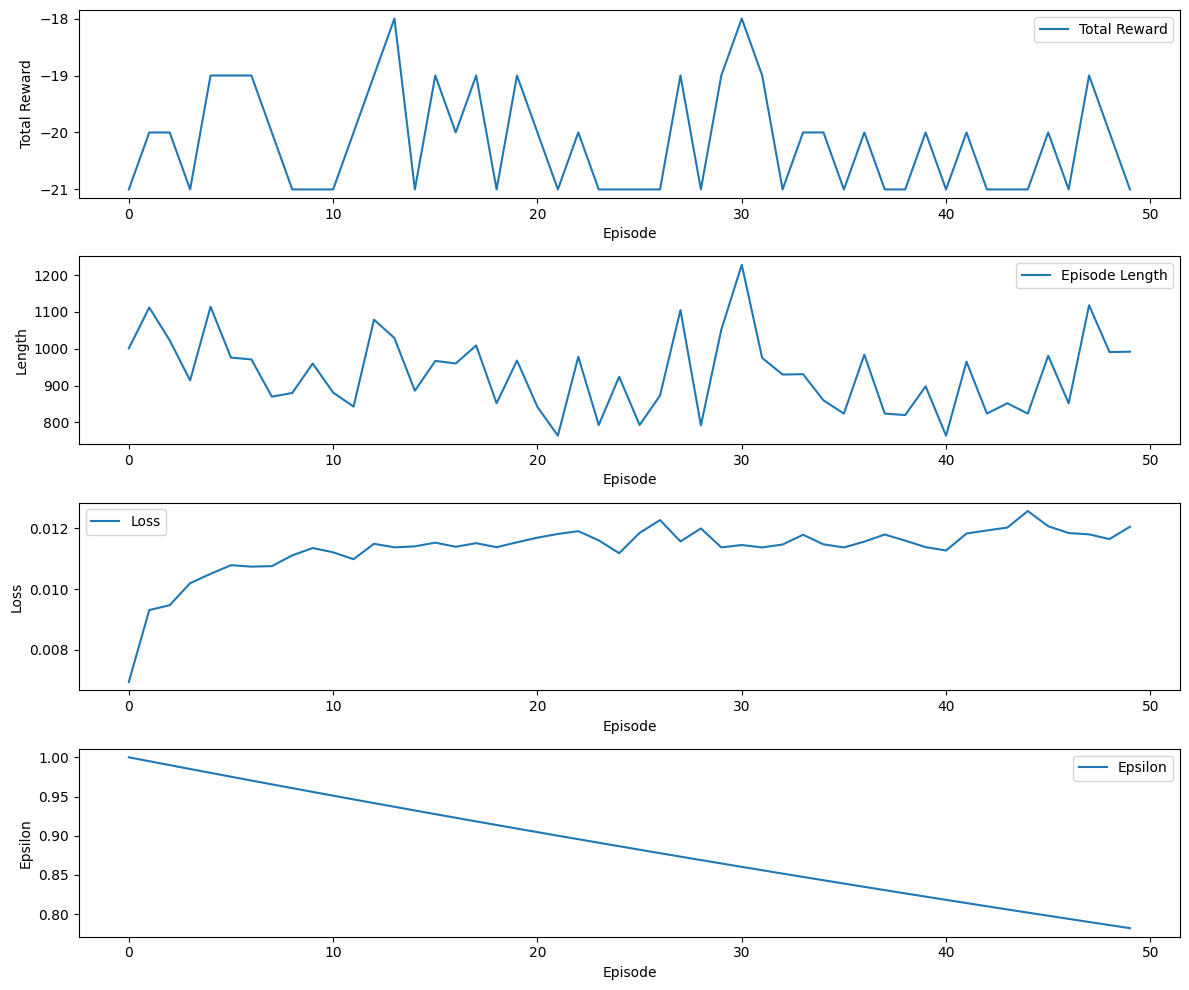

Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-50.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-50.mp4
Episode 51 abgeschlossen mit 964 Schritten, Gesamtbelohnung: -20.0, Epsilon: 0.778312557068642
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-51.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-51.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-51.mp4
Episode 52 abgeschlossen mit 824 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.7744209942832988
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-52.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-52.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-52.mp4
Episode 53 abgeschlossen mit 792 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.7705488893118823
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-53.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-53.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-53.mp4
Episode 54 abgeschlossen mit 854 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.7666961448653229
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-54.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-54.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-54.mp4
Episode 55 abgeschlossen mit 956 Schritten, Gesamtbelohnung: -19.0, Epsilon: 0.7628626641409962
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-55.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-55.mp4
Episode 56 abgeschlossen mit 764 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.7590483508202912
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-56.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-56.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-56.mp4
Episode 57 abgeschlossen mit 1013 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.7552531090661897
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-57.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-57.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-57.mp4
Episode 58 abgeschlossen mit 994 Schritten, Gesamtbelohnung: -20.0, Epsilon: 0.7514768435208588
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-58.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-58.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-58.mp4
Episode 59 abgeschlossen mit 963 Schritten, Gesamtbelohnung: -20.0, Epsilon: 0.7477194593032545
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-59.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-59.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-59.mp4
Episode 60 abgeschlossen mit 1088 Schritten, Gesamtbelohnung: -19.0, Epsilon: 0.7439808620067382


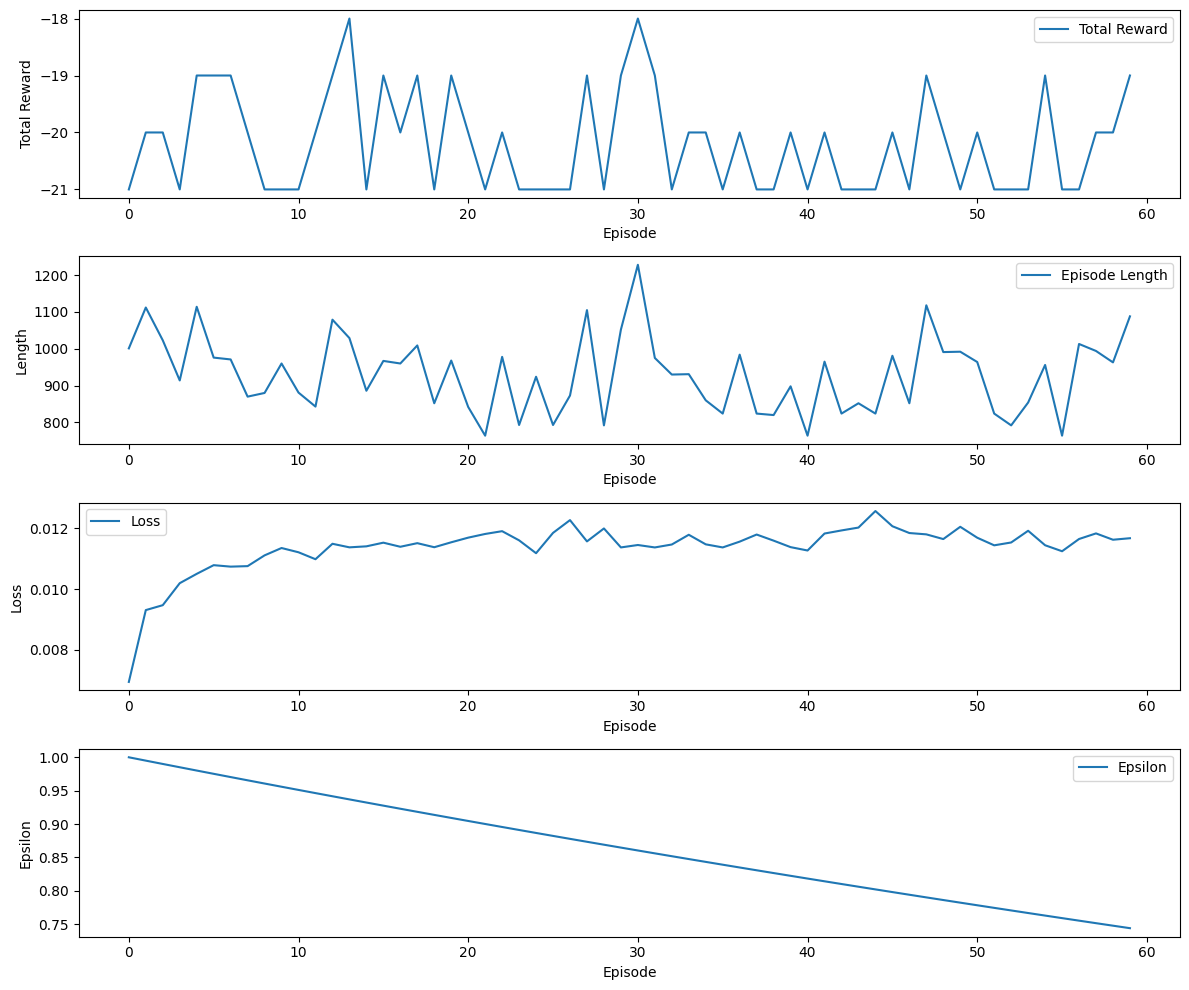

Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-60.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-60.mp4
Episode 61 abgeschlossen mit 764 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.7402609576967045
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-61.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-61.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-61.mp4
Episode 62 abgeschlossen mit 814 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.736559652908221
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-62.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-62.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-62.mp4
Episode 63 abgeschlossen mit 826 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.7328768546436799
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-63.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-63.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-63.mp4
Episode 64 abgeschlossen mit 894 Schritten, Gesamtbelohnung: -20.0, Epsilon: 0.7292124703704616
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-64.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-64.mp4
Episode 65 abgeschlossen mit 764 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.7255664080186093
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-65.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-65.mp4
Episode 66 abgeschlossen mit 884 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.7219385759785162
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-66.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-66.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\videos\rl-video-episode-66.mp4
Episode 67 abgeschlossen mit 916 Schritten, Gesamtbelohnung: -21.0, Epsilon: 0.7183288830986236


KeyboardInterrupt: 

In [22]:
# training metrics
episode_rewards = []
episode_lengths = []
episode_losses = []
epsilon_values = []

buffer = ExperienceReplayBuffer()
best_reward = -float('inf') 

for episode in range(num_episodes):
    env.reset() 
    state, info = env.reset()
    state = preprocess_state(state)  # Preprocessing of the state
    state = np.stack([state] * 4, axis=2)  # Stacking of the state 4 times
    done = False
    total_reward = 0
    step = 0  # step counter for the episode
    losses = []

    while not done: # loop through steps
        if np.random.rand() <= epsilon: # epsilon greedy policy
            action = env.action_space.sample() # take random action
        else:
            action = np.argmax(model.predict(np.expand_dims(state, axis=0), verbose=0))

        # Frame skipping logic
        #for _ in range(frame_skip):
        #    next_state, reward, done, truncated, info = env.step(action)
        #    done = done or truncated
        #    total_reward += reward
        #    if done:
        #        break

        next_state, reward, done, truncated, info = env.step(action) # take action in the environment
        done = done or truncated  # check if the episode is done or truncated

        next_state = preprocess_state(next_state)  
        next_state = np.append(state[:, :, 1:], np.expand_dims(next_state, axis=2), axis=2)

        total_reward += reward

        buffer.add(state, action, reward, next_state, done)

        state = next_state
        step += 1  

        if len(buffer.buffer) > batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)

            # Q-Learning
            future_rewards = target_model.predict(np.array(next_states), verbose=0) # predict future rewards with target model
            dones = np.array(dones, dtype=int) # convert dones to int

            updated_q_values = rewards + discount_factor * np.max(future_rewards, axis=1) * (1 - dones) # calculate updated q values

            masks = tf.one_hot(actions, action_space_n) # create masks 

            with tf.GradientTape() as tape: # calculate loss
                q_values = model(np.array(states))
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                loss = huber_loss(updated_q_values, q_action)
                losses.append(loss.numpy())

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        #print(f"Episode: {episode + 1}, Step: {step}, Step Reward: {reward}, Total Reward: {total_reward}, Epsilon: {epsilon}")

    episode_rewards.append(total_reward) #append total reward to list
    episode_lengths.append(step) #append step to list
    episode_losses.append(np.mean(losses)) #append loss to list
    epsilon_values.append(epsilon) #append epsilon to list

    print(f"Episode {episode + 1} abgeschlossen mit {step} Schritten, Gesamtbelohnung: {total_reward}, Epsilon: {epsilon}")

    if episode % 10 == 0:
        target_model.set_weights(model.get_weights())

    epsilon = max(epsilon_min, epsilon * epsilon_decay) 

    if total_reward > best_reward:  # save best model
        best_reward = total_reward
        model.save("best_pong_v5_rl_model.keras")

    if (episode + 1) % 100 == 0: #save model every 100 episodes
        model.save(f"pong_v5_rl_model_episode_{episode + 1}.keras")

    if (episode + 1) % 10 == 0: 
        plot_results(episode_rewards, episode_lengths, episode_losses, epsilon_values, save_path= f"pong_Plot_episode_{episode + 1}.png")      
         

model.save("pong_rl_model.keras") #save model

In [5]:
#model evaluation
from tensorflow.keras.models import load_model
model = load_model("pong_v5_rl_model_episode_1000.keras") #load best model
env = gym.make("ALE/Pong-v5", render_mode='rgb_array') #create environment
env = gym.wrappers.RecordVideo(env, './eval_vid', episode_trigger=lambda episode_id: True, video_length=0)
total_rewards = []

for _ in range(10):
    total_reward = 0
    step = 0
    state, info = env.reset()
    state = preprocess_state(state)
    state = np.stack([state] * 4, axis=2)
    done = False
    while not done:
        action = np.argmax(model.predict(np.expand_dims(state, axis=0), verbose=0))
        next_state, reward, done, truncated, info = env.step(action)
        done = done or truncated
        total_reward += reward
        next_state = preprocess_state(next_state)
        next_state = np.append(state[:, :, 1:], np.expand_dims(next_state, axis=2), axis=2)
        state = next_state
        step += 1
    total_rewards.append(total_reward)
    env.close()
    print(f"Total Reward: {total_reward}, Steps: {step}")
avg_reward = np.mean(total_rewards)
print("Durchschnittliche Belohnung über", num_episodes, "Episoden:", avg_reward)


c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\.venv\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\.venv\Lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-0.mp4
Total Reward: -8.0, Steps: 2575
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-1.mp4
Total Reward: -10.0, Steps: 2580
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-2.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-2.mp4
Total Reward: -1.0, Steps: 2873
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-3.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-3.mp4
Total Reward: -8.0, Steps: 2450
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-4.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-4.mp4
Total Reward: -11.0, Steps: 2078
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-5.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-5.mp4
Total Reward: 5.0, Steps: 2638
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-6.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-6.mp4
Total Reward: -13.0, Steps: 1861
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-7.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-7.mp4
Total Reward: -11.0, Steps: 2149
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-8.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-8.mp4
Total Reward: -12.0, Steps: 2191
Moviepy - Building video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-9.mp4.
Moviepy - Writing video c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\alexp\OneDrive\Studium\6_Semester\Reinforcement_Learning\RL\eval_vid\rl-video-episode-9.mp4
Total Reward: -9.0, Steps: 2141
Durchschnittliche Belohnung über 1000 Episoden: -7.8
